# SARSA(lambda)

In [1]:
# Find the value function of policy
import numpy as np
import matplotlib.pyplot as plt
# display output
import random
from random import uniform
import time
from IPython.display import display, clear_output

In [2]:
actions = [[-1, 0], [0, 1], [1, 0], [0, -1]] #up, right, down, left = (clockwise from up) 
action_count = len(actions) # total number of actions
gridSize = 5 # create a square grid of gridSize by gridSize
state_count = gridSize*gridSize # total number of states

In [3]:
class Gridworld():
    def __init__(self, gridSize):
        self.valueMap = np.zeros((gridSize, gridSize))
        self.states = [[i, j] for i in range(gridSize) for j in range(gridSize)]
        self.size = gridSize
        self.new_pos = [0, 0] # initialize new position for p_transition
        self.transition_prob = 1 # deterministic
    
    def initial_state(self):        # return initial state
        return grid.states[gridSize*gridSize-1]
   
    def transition_reward(self, current_pos, action): # return the transition probability

        # get next position: state: [0, 0], action: [0, 1], new_state = [0, 1]
        self.new_pos = np.array(current_pos) + np.array(action)

        # normally, reward = 0
        reward = 0

        # if new pos results in off the grid, return reward -1
        if -1 in self.new_pos or self.size in self.new_pos:
            reward = -1
        # if in state A, receive + 10
        if current_pos == [0, 1]:
            reward = 10
        # if in state B, receive + 5
        if current_pos == [0, 3]:
            reward = 5

        # if taking an action crosses the border; agent's new_pos is the same as the current pos
        if -1 in self.new_pos or self.size in self.new_pos: 
            self.new_pos = current_pos
            
        # if in state A, transition to state A'
        if current_pos == [0, 1]:
            self.new_pos = [4, 1]
            
        # if in state B, transition to state B'
        if current_pos == [0, 3]:
            self.new_pos = [2, 3]

        return self.new_pos, reward

In [4]:
# create a grid object
grid = Gridworld(5)

In [5]:
# get initial state (bottom right)
grid.initial_state()

[4, 4]

### SARSA(Lamda)

In [6]:
# initialize q values for all state action pairs
Q_values = np.random.randint(0,1000,size = (state_count, action_count))
Q_values

array([[484, 596, 841, 792],
       [264, 558, 789, 241],
       [573, 262,  48, 282],
       [995, 109, 721,  23],
       [601, 173, 480, 774],
       [289,   1, 892, 399],
       [210, 598, 707, 314],
       [936, 583, 563, 741],
       [367, 476, 337, 333],
       [973, 319,  87, 813],
       [679, 545, 445, 224],
       [880, 224, 739, 151],
       [688, 634, 192, 347],
       [376, 959, 410, 459],
       [126,  24, 514, 316],
       [368, 498,  31, 602],
       [853, 504, 377, 539],
       [588, 870, 142, 355],
       [ 27, 667, 148, 399],
       [209, 242, 407, 304],
       [812, 941, 199, 417],
       [117, 942, 144, 254],
       [240, 931, 488, 584],
       [203, 690, 932, 141],
       [483, 309, 593, 290]])

In [7]:
# intialize parameters
gamma = 0.99
epsilon = 0.1
lamda = 0.9
alpha = 0.1

In [8]:
# iterate 500 times: each time, generating an episode of 200 steps
max_steps = 200

# define variables for keeping track of time steps
Terminal = max_steps
t_list=[]
for i in range(1,max_steps+1):
    t = Terminal - i
    t_list.append(t)

In [9]:
def choose_action(state, epsilon):
    
    # choose an action type: explore or exploit
    action_type = int(np.random.choice(2, 1, p=[epsilon,1-epsilon]))

    # find best action based on Q values
    best_action_index = np.argmax(Q_values[state])

    # pick a random action
    random_action_index = random.choice(range(4))

    # choose an action based on exploit or explore
    if action_type == 0:
        
        # while random action is the same as the best action, pick a new action
        while random_action_index == best_action_index:
            random_action_index = random.choice(range(4))
        
        # explore
        # print("explore")
        action_index = random_action_index
    else:
        # exploit
        # print("exploit")
        action_index = best_action_index
        
    return action_index

In [10]:
# initialize q values for all state action pairs
Q_values = np.zeros((state_count, action_count))

In [11]:
# define average function
def Average(lst): 
    return sum(lst) / len(lst) 

In [12]:
average_reward_list = []
cumulative_reward_list = []
cumulative_reward = 0
delta_list = []

# iteration 500 times
for iteration in range(500):
    
    # initialize delta
    delta_ = 0
    
    # delta for change in Q values
    delta = 0
    
    # initialize S,A (? should i choose an Action using epsilon-greedy here or just select an Action?)
    state_vector = grid.initial_state()
    state_index = grid.states.index(state_vector)
    
    # initialize  eligibility traces for all state action pairs of all states to 0
    z_values = np.zeros((state_count, action_count))
    
    action_index = choose_action(state_index, epsilon)
    action_vector = actions[action_index]
    
    reward_list = []
    
    # iteration 200 steps of the episode
    for i in range(max_steps):

        # Take action A, oberserve R, S'
        next_state_vector, reward = grid.transition_reward(state_vector, action_vector)
        next_state_index = grid.states.index(list(next_state_vector))
        
        reward_list.append(reward)

        # Choose A' from S' using policy derived from Q (eg. epsilon-greedy)
        next_action_index = choose_action(next_state_index, epsilon)
        next_action_vector = actions[next_action_index]

        # update the action-value form of the TD error
        delta_ = reward + gamma*Q_values[next_state_index][next_action_index] - Q_values[state_index][action_index]
        
        # accumulate traces (? big S and big A?)
        z_values[state_index][action_index] +=1
        
        # calculate max Q_value change for plotting max delta
        Q_value = Q_values[state_index][action_index] + alpha*delta_*z_values[state_index][action_index]
        delta = max(delta, np.abs(Q_value - Q_values[state_index][action_index]))   
        
        # update Q value
        Q_values[state_index][action_index] = Q_values[state_index][action_index] + alpha*delta_*z_values[state_index][action_index]
        
        # update z value
        z_values[state_index][action_index] = gamma*lamda*z_values[state_index][action_index]
        
        # update state and action vector
        state_vector = list(next_state_vector)
        state_index = grid.states.index(state_vector)
        action_vector = list(next_action_vector)
        action_index = next_action_index
    
    delta_list.append(delta)
    
    average_reward_list.append(Average(reward_list))
    
    cumulative_reward = cumulative_reward + sum(reward_list)
    cumulative_reward_list.append(cumulative_reward)

Text(0, 0.5, 'Max Delta')

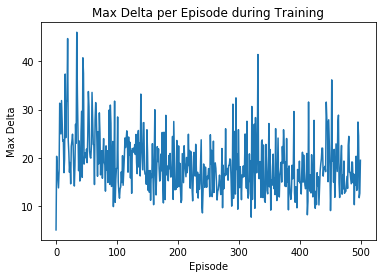

In [13]:
# max delta of each episode, where delta is the change in Q values
plt.plot(delta_list)
plt.title('Max Delta per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Max Delta')

Text(0, 0.5, 'Average Reward')

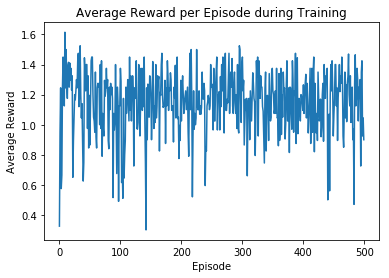

In [14]:
# average reward per episode
plt.plot(average_reward_list)
plt.title('Average Reward per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Average Reward')

Text(0, 0.5, 'Cumulative Reward')

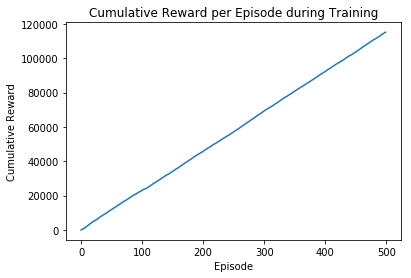

In [15]:
# cumulative reward per episode
plt.plot(cumulative_reward_list)
plt.title('Cumulative Reward per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')

In [16]:
z_values

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [1.684881  , 7.45007112, 6.35099838, 0.891     ],
       [0.        , 0.        , 1.684881  , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.684881  , 0.        ],
       [8.0600435 , 5.59663641, 0.        , 0.891     ],
       [1.684881  , 2.39222897, 0.891     , 6.12794431],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.891     , 6.35099838, 0.891     , 0.        ],
       [8.0600435 , 3.02247601, 2.39222897, 6.35099838],
       [2.39222897, 0.891     , 0.891     , 0.891     ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.891     ,

In [17]:
np.set_printoptions(precision=2)
Q_values

array([[ 1.81e+00,  1.98e+01,  0.00e+00,  1.30e+00],
       [ 1.99e+01,  9.35e+00,  1.31e+01,  2.94e+01],
       [ 2.22e+01,  6.78e+01,  2.48e+01,  9.35e+00],
       [ 7.04e+01,  6.71e+01,  6.75e+01,  6.77e+01],
       [ 9.22e+00,  6.28e+00,  6.04e+01,  1.77e+01],
       [ 8.16e+00,  0.00e+00,  9.52e-01, -9.99e-02],
       [ 2.37e+01,  5.99e+01,  2.49e+01,  3.49e+00],
       [ 5.32e+01,  5.67e+01,  6.37e+01,  4.16e+01],
       [ 7.12e+01,  6.77e+01,  6.35e+01,  6.08e+01],
       [ 4.84e+01,  6.30e+01,  5.88e+01,  6.95e+01],
       [ 2.36e-01,  3.32e+01,  5.47e-01,  0.00e+00],
       [ 6.08e+01,  2.79e+01,  1.01e+01,  1.38e+01],
       [ 5.65e+01,  5.93e+01,  5.69e+01,  5.78e+01],
       [ 6.95e+01,  5.95e+01,  5.91e+01,  5.81e+01],
       [ 6.09e+01,  5.61e+01,  5.04e+01,  6.11e+01],
       [ 3.20e-01,  9.83e+00,  0.00e+00,  2.97e-01],
       [ 4.26e+01,  9.12e+00,  9.33e+00,  7.37e-01],
       [ 6.30e+01,  4.22e+01,  1.15e+01,  1.72e+01],
       [ 5.92e+01,  4.96e+01,  5.83e+01,  5.12

## Visualization 

In [18]:
# PRINT POLICY TABLE ################################################################################
# import pandas library
import pandas as pd
# define column and index
columns=range(grid.size)
index = range(grid.size)
# define dataframe to represent policy table
policy_table = pd.DataFrame(index = index, columns=columns)

# iterate through policy to make a table that represents action number
# as action name (eg. left, right, up, down)
for state in range(len(Q_values)):
    
    # find the best action at each state
    best_action = np.argmax(Q_values[state])

    # get action name
    if best_action == 0:
        action_name = 'up'
    elif best_action == 1:
        action_name = 'right'
    elif best_action == 2:
        action_name = 'down'
    else:
        action_name = 'left'

    # calculate the row and column coordinate of the current state number
    row = int(state/grid.size)
    column = round((state/grid.size - int(state/grid.size))*grid.size)
            
    # assign action name
    policy_table.loc[row][column] = action_name

print("Policy Table: ")
print(policy_table)
print()

Policy Table: 
       0      1      2   3     4
0  right   left  right  up  down
1     up  right   down  up  left
2  right     up  right  up  left
3  right     up     up  up  down
4     up     up  right  up  left

